In [1]:
import pandas as pd
import json

# Import the data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**Create the base dataframe from which the analysis will take place.**

In [2]:
# Create a DataFrame from the JSON file
path = 'resources/neo_data.json'

df_original = pd.read_json(path)
df_original.info()

def remove_unnecessary_columns(df):
    '''
        Drop the columns that serve to identify the Near Earth Object, which are
        assigned by NASA and not scientifically descriptive of the object itself.
        Return a dataframe without the unnecessary columns.
    '''
    # Create a new DataFrame
    df_columns_removed = df.copy()
    superfluous_columns = ['name', 'id', 'orbiting_body']
    # Drop the superfluous columns
    df_columns_removed.drop(superfluous_columns, axis=1, inplace=True)
    return df_columns_removed

base_df = remove_unnecessary_columns(df_original)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8218 entries, 0 to 8217
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        8218 non-null   int64  
 1   name                      8218 non-null   object 
 2   absolute_magnitude_h      8218 non-null   float64
 3   est_diameter_min          8218 non-null   float64
 4   est_diameter_max          8218 non-null   float64
 5   relative_velocity         8218 non-null   float64
 6   miss_distance             8218 non-null   float64
 7   orbiting_body             8218 non-null   object 
 8   sentry_object             8218 non-null   int64  
 9   is_potentially_hazardous  8218 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 642.2+ KB


**Preliminary model experiments**

In [3]:
def get_features_set(df):
    X = df.copy()
    # Drop the target column
    X.drop('is_potentially_hazardous', axis=1, inplace=True)
    return X

# Define the features set and drop the target column
X = get_features_set(base_df)
X.head()

,absolute_magnitude_h,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,sentry_object
0,25.60,0.020163,0.045086,41072.828534,3.868955e+07,0
1,21.16,0.155796,0.348369,51223.885782,4.771584e+07,0
2,26.30,0.014607,0.032662,12712.104884,2.388379e+07,0
3,24.44,0.034400,0.076920,25376.064524,4.844917e+07,0
4,23.60,0.050647,0.113250,88941.661927,6.288475e+07,0


In [4]:
# Define the target vector
y = base_df['is_potentially_hazardous'].copy()
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: is_potentially_hazardous, dtype: int64

In [5]:
# check value_counts
y.value_counts()

is_potentially_hazardous
0    7666
1     552
Name: count, dtype: int64

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [7]:
# No testing has been done yet to determine the data is distrubuted normally.
# We will use both the StandardScaler and the MinMaxScaler to determine which
# one is best for this dataset. Let's start with the StandardScaler.
standard_scaler = StandardScaler().fit(X_train)
X_train_scaled = standard_scaler.transform(X_train)
X_train_scaled

array([[ 1.09778354, -0.47152658, -0.47152658, -0.79797486,  1.65207245,
        -0.245377  ],
       [ 0.43401193, -0.39557784, -0.39557784, -0.39874631,  0.45099066,
        -0.245377  ],
       [ 0.79171108, -0.44413588, -0.44413588, -0.77043553, -0.9726628 ,
        -0.245377  ],
       ...,
       [ 0.67739485, -0.4309042 , -0.4309042 , -0.63553589, -1.12959817,
        -0.245377  ],
       [-0.27401111, -0.20404563, -0.20404563, -0.55904761, -0.55003616,
        -0.245377  ],
       [ 1.06090734, -0.46875375, -0.46875375, -0.81100614,  1.16565367,
        -0.245377  ]])

In [8]:
# Scale the testing dataset
X_test_scaled = standard_scaler.transform(X_test)
X_test_scaled

array([[-1.51305144,  1.00297937,  1.00297937,  1.26557985,  0.83453882,
        -0.245377  ],
       [ 0.37132239, -0.38460183, -0.38460183, -0.90277169, -0.8850526 ,
        -0.245377  ],
       [-0.18182061, -0.23953223, -0.23953223, -0.35660015, -0.19164171,
        -0.245377  ],
       ...,
       [ 0.58889197, -0.41928123, -0.41928123, -1.32144064, -0.51966709,
        -0.245377  ],
       [ 0.03943659, -0.30974506, -0.30974506, -0.73727885,  1.1297422 ,
        -0.245377  ],
       [ 1.13097212, -0.47391526, -0.47391526, -1.24773121, -1.07862912,
        -0.245377  ]])

In [9]:
# Check the max and min of the scaled training and testing sets
print("Scaled data min/max (StandardScaler):")
print("Training data min:",X_train_scaled.min())
print("Training data max:",X_train_scaled.max())
print("Testing data min:",X_test_scaled.min())
print("Testing data max:",X_test_scaled.max())

Scaled data min/max (StandardScaler):
Training data min: -3.6297453248308886
Training data max: 21.029146296594423
Testing data min: -3.4564271840361647
Testing data max: 16.833201185394756


In [10]:
# Try the MinMaxScaler
minmax_scaler = MinMaxScaler().fit(X_train)
X_train_minmax = minmax_scaler.transform(X_train)
X_train_minmax

array([[0.70131291, 0.00250873, 0.00250873, 0.15494274, 0.93560181,
        0.        ],
       [0.60284464, 0.00603226, 0.00603226, 0.2156308 , 0.56394385,
        0.        ],
       [0.6559081 , 0.00377948, 0.00377948, 0.15912909, 0.12341421,
        0.        ],
       ...,
       [0.63894967, 0.00439335, 0.00439335, 0.17963563, 0.07485276,
        0.        ],
       [0.49781182, 0.01491811, 0.01491811, 0.19126287, 0.25419011,
        0.        ],
       [0.69584245, 0.00263737, 0.00263737, 0.15296181, 0.78508632,
        0.        ]])

In [11]:
X_test_minmax = minmax_scaler.transform(X_test)
X_test_minmax

array([[0.31400438, 0.07091621, 0.07091621, 0.46863054, 0.68262746,
        0.        ],
       [0.59354486, 0.00654147, 0.00654147, 0.13901223, 0.15052396,
        0.        ],
       [0.51148796, 0.01327176, 0.01327176, 0.22203758, 0.36509026,
        0.        ],
       ...,
       [0.62582057, 0.00493258, 0.00493258, 0.07536897, 0.2635874 ,
        0.        ],
       [0.54431072, 0.01001434, 0.01001434, 0.16416934, 0.77397402,
        0.        ],
       [0.70623632, 0.00239791, 0.00239791, 0.08657379, 0.09062442,
        0.        ]])

In [12]:
# Check the max and min of the scaled training and testing sets
print("Scaled data min/max (MinMaxScaler):")
print("Training data min:",X_train_minmax.min())
print("Training data max:",X_train_minmax.max())
print("Testing data min:",X_test_minmax.min())
print("Testing data max:",X_test_minmax.max())

Scaled data min/max (MinMaxScaler):
Training data min: 0.0
Training data max: 1.0000000000000002
Testing data min: 0.0
Testing data max: 1.0107488564339902


KNN and DecisionTree models were created on a separate file and showed accuracy scores of 1.0, demonstrating that the model is overfitting.

In [13]:
svc_standard = SVC(kernel='rbf')
svc_standard.fit(X_train_scaled, y_train)

SVC()

In [14]:
# Validate the model by checking the model accuracy with model.score
print('Train Accuracy: %.3f' % svc_standard.score(X_train_scaled, y_train))
print('Test Accuracy: %.3f' % svc_standard.score(X_test_scaled, y_test))

Train Accuracy: 0.940
Test Accuracy: 0.931


In [15]:
svc_minmax = SVC(kernel='rbf')
svc_minmax.fit(X_train_minmax, y_train)

SVC()

In [16]:
# validate the model by checking the model accuracy with model.score
print('Train Accuracy: %.3f' % svc_minmax.score(X_train_minmax, y_train))
print('Test Accuracy: %.3f' % svc_minmax.score(X_test_minmax, y_test))

Train Accuracy: 0.935
Test Accuracy: 0.927


In [17]:
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 40 in steps of 2
depths = range(1, 10, 1)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {'train': [], 'test': [], 'depth': []}

# Loop through each depth (this will take time to run)
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train_scaled, y_train)

    train_score = clf.score(X_train_scaled, y_train)
    test_score = clf.score(X_test_scaled, y_test)

    scores['depth'].append(depth)
    scores['train'].append(train_score)
    scores['test'].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index('depth')

scores_df.head()

,train,test
depth,,
1,0.934772,0.927007
2,0.935259,0.927007
3,0.943696,0.935280
4,0.944508,0.936253
5,0.944508,0.936740


<Axes: xlabel='depth'>

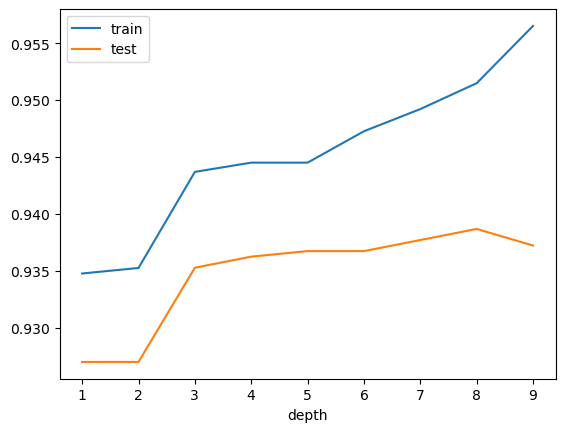

In [18]:
# Plot the scores dataframe with the plot method
scores_df.plot()

In [19]:
# Create a Random Forest model
classifier = RandomForestClassifier(random_state=13, max_depth=3, n_estimators=100)

# Fit (train) or model using the training data
classifier.fit(X_train_scaled, y_train)

# Calculate the accuracy of the model on the testing data
classifier.score(X_test_scaled, y_test)


0.9352798053527981

In [20]:
# Calculate the accuracy of the model on the training data
classifier.score(X_train_scaled, y_train)

0.9436962518254097

In [21]:
# Check the model's balanced accuracy on the test set

y_test_pred = classifier.predict(X_test_scaled)
print(balanced_accuracy_score(y_test, y_test_pred))

0.5689501312335958


It looks like the model does well at identifying when an object is not dangerous, but it does relatively poorly when trying to identify dangerous objects. This is a problem! 

In [22]:
# Check the model's confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[1901,    4],
       [ 129,   21]])

**Model Optimization**

In [23]:
# Fine Tuning: Should do some overfitting and balanced_score testing
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler instance
random_oversampler = RandomOverSampler(random_state=1)

# Fit the data to the model
X_resampled, y_resampled = random_oversampler.fit_resample(
                                                X_train_scaled, y_train)


In [24]:
# Count distinct values
y_resampled.value_counts()

is_potentially_hazardous
0    5761
1    5761
Name: count, dtype: int64

In [25]:
# Create a RandomForestClassifier instance and fit it to the resampled data
resampled_model = RandomForestClassifier(random_state=13, max_depth=3, n_estimators=100)
resampled_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=3, random_state=13)

In [26]:
# Make predictions for testing features
y_pred = classifier.predict(X_test_scaled)
y_pred_resampled = resampled_model.predict(X_test_scaled)

In [27]:
# Print the classification reports for the two models
original_classification_report = classification_report(y_test, y_pred)
print(original_classification_report)
print('----------')
print('Resampled using Random Oversampler:')
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1905
           1       0.84      0.14      0.24       150

    accuracy                           0.94      2055
   macro avg       0.89      0.57      0.60      2055
weighted avg       0.93      0.94      0.91      2055

----------
Resampled using Random Oversampler:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1905
           1       0.31      0.99      0.48       150

    accuracy                           0.84      2055
   macro avg       0.66      0.91      0.69      2055
weighted avg       0.95      0.84      0.88      2055



In [28]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE instance 
# Set the sampling_strategy parameter equal to auto
smote_sampler = SMOTE(random_state=1, sampling_strategy='auto')

In [29]:
# Fit the training data to the smote_sampler model
X_resampled_smote, y_resampled_smote = smote_sampler.fit_resample(X_train_scaled, y_train)

In [30]:
# Count distinct values for the resampled target data
y_resampled_smote.value_counts()

is_potentially_hazardous
0    5761
1    5761
Name: count, dtype: int64

In [31]:
# Instantiate a new RandomForestClassier model 
smote_model = RandomForestClassifier()

# Fit the resampled data to the new model
smote_model.fit(X_resampled_smote, y_resampled_smote)

RandomForestClassifier()

In [32]:
# Predict labels for resampled testing features
smote_y_pred = smote_model.predict(X_test_scaled)

In [33]:
# Print classification reports
print(f"Classification Report - Original Data")
print(original_classification_report)
print("---------")
print(f"Classification Report - Resampled Data - SMOTE")
print(classification_report(y_test, smote_y_pred))

Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1905
           1       0.84      0.14      0.24       150

    accuracy                           0.94      2055
   macro avg       0.89      0.57      0.60      2055
weighted avg       0.93      0.94      0.91      2055

---------
Classification Report - Resampled Data - SMOTE
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1905
           1       0.41      0.74      0.52       150

    accuracy                           0.90      2055
   macro avg       0.69      0.83      0.73      2055
weighted avg       0.94      0.90      0.91      2055



**Performance is improving, but not enough. Let's try adding more data from the NASA API**

In [34]:
# Import the additional data file from JSON into a dataframe
path = 'resources/additional_neo_data.json'
df_additional = pd.read_json(path)

# Count the instances of is_potentially_hazardous == 1
df_additional['is_potentially_hazardous'].value_counts()

is_potentially_hazardous
0    22677
1     1612
Name: count, dtype: int64

In [35]:
# Get a dataframe of the minority class
minority_class_df = df_additional[df_additional['is_potentially_hazardous'] == 1]

minority_class_df = remove_unnecessary_columns(minority_class_df)
minority_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1612 entries, 0 to 24274
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   absolute_magnitude_h      1612 non-null   float64
 1   est_diameter_min          1612 non-null   float64
 2   est_diameter_max          1612 non-null   float64
 3   relative_velocity         1612 non-null   float64
 4   miss_distance             1612 non-null   float64
 5   sentry_object             1612 non-null   int64  
 6   is_potentially_hazardous  1612 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 100.8 KB


In [36]:
# Combine the minority class dataframe with the base dataframe
combined_df = pd.concat([base_df, minority_class_df], ignore_index=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   absolute_magnitude_h      9830 non-null   float64
 1   est_diameter_min          9830 non-null   float64
 2   est_diameter_max          9830 non-null   float64
 3   relative_velocity         9830 non-null   float64
 4   miss_distance             9830 non-null   float64
 5   sentry_object             9830 non-null   int64  
 6   is_potentially_hazardous  9830 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 537.7 KB


In [37]:
# Check the value counts of the target column
combined_df['is_potentially_hazardous'].value_counts()

is_potentially_hazardous
0    7666
1    2164
Name: count, dtype: int64

In [38]:
# Define the new features set and drop the target column
X = get_features_set(combined_df)


In [39]:
# Define the target vector
y = combined_df['is_potentially_hazardous'].copy()

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [41]:
# Scale with Standard Scaler
standard_scaler = StandardScaler().fit(X_train)
X_train_scaled = standard_scaler.transform(X_train)

# Scale the testing dataset
X_test_scaled = standard_scaler.transform(X_test)


<Axes: xlabel='depth'>

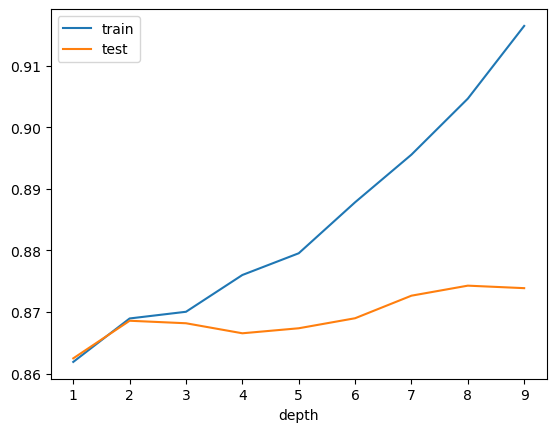

In [42]:
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 20 in steps of 2
depths = range(1, 10, 1)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {'train': [], 'test': [], 'depth': []}

# Loop through each depth (this will take time to run)
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train_scaled, y_train)

    train_score = clf.score(X_train_scaled, y_train)
    test_score = clf.score(X_test_scaled, y_test)

    scores['depth'].append(depth)
    scores['train'].append(train_score)
    scores['test'].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index('depth')

scores_df.plot()

In [43]:
# Create a Random Forest model
classifier = RandomForestClassifier(random_state=13, max_depth=3, n_estimators=100)

# Fit (train) or model using the training data
classifier.fit(X_train_scaled, y_train)

# Calculate the accuracy of the model on the testing data
print(f"Testing data accuracy score: {classifier.score(X_test_scaled, y_test)}")

# Calculate the accuracy of the model on the training data
print(f"Training data accuracy score: {classifier.score(X_train_scaled, y_train)}")

# Check the model's balanced accuracy on the test set
y_test_pred = classifier.predict(X_test_scaled)
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_test_pred)}")

Testing data accuracy score: 0.8677786818551668
Training data accuracy score: 0.8700488334237656
Balanced Accuracy Score: 0.9088360226645182


In [44]:
# Make predictions for testing features
y_pred = classifier.predict(X_test_scaled)

In [45]:
# Print the classification reports for the two models
print("Classification Report - Original Data")
print(original_classification_report)
print('----------------')
print('Classification Report: New Data Added')
print(classification_report(y_test, y_pred))

Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1905
           1       0.84      0.14      0.24       150

    accuracy                           0.94      2055
   macro avg       0.89      0.57      0.60      2055
weighted avg       0.93      0.94      0.91      2055

----------------
Classification Report: New Data Added
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      1902
           1       0.63      0.98      0.77       556

    accuracy                           0.87      2458
   macro avg       0.81      0.91      0.84      2458
weighted avg       0.91      0.87      0.88      2458



**Let's see if we can get precision and f1-score up a bit more by trying to use SMOTE with the new data set**

In [46]:
def generate_smote_models(X_train_scaled, y_train, X_test_scaled, y_test, original_classification_report):
    # Instantiate the SMOTE instance 
    # Set the sampling_strategy parameter equal to auto
    smote_sampler = SMOTE(random_state=1, sampling_strategy='auto')
    # Fit the training data to the smote_sampler model
    X_resampled_smote, y_resampled_smote = smote_sampler.fit_resample(X_train_scaled, y_train)
    # Instantiate a new RandomForestClassier model 
    smote_model = RandomForestClassifier()

    # Fit the resampled data to the new model
    smote_model.fit(X_resampled_smote, y_resampled_smote)
    # Predict labels for resampled testing features
    smote_y_pred = smote_model.predict(X_test_scaled)
    # Calculate the accuracy of the model on the testing data
    print(f"Testing data accuracy score: {smote_model.score(X_test_scaled, y_test)}")

    # Calculate the accuracy of the model on the training data
    print(f"Training data accuracy score: {smote_model.score(X_resampled_smote, y_resampled_smote)}")

    # Check the model's balanced accuracy on the test set
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, smote_y_pred)}")
    print('---------')
    print(f"Classification Report - Original Data")
    print(original_classification_report)
    print("---------")
    print(f"Classification Report - Resampled and Added Data - SMOTE")
    print(classification_report(y_test, smote_y_pred))
    return smote_model

generate_smote_models(X_train_scaled, y_train, X_test_scaled, y_test, original_classification_report)

Testing data accuracy score: 0.8925956061838893
Training data accuracy score: 1.0
Balanced Accuracy Score: 0.9013249967849064
---------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1905
           1       0.84      0.14      0.24       150

    accuracy                           0.94      2055
   macro avg       0.89      0.57      0.60      2055
weighted avg       0.93      0.94      0.91      2055

---------
Classification Report - Resampled and Added Data - SMOTE
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1902
           1       0.70      0.92      0.79       556

    accuracy                           0.89      2458
   macro avg       0.84      0.90      0.86      2458
weighted avg       0.91      0.89      0.90      2458



RandomForestClassifier()